**Проект: Линейные модели в машинном обучении**

**Описание проекта**

Описание проекта

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».


Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

1. Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
import scipy.stats as st
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import OneHotEncoder

## Шаг 1. Загрузка данных

### 1.1 Чтение файлов

In [3]:
data_ferma = pd.read_csv("/datasets/ferma_main.csv" , sep = ";" , decimal = ",")
data_name_dad = pd.read_csv("/datasets/ferma_dad.csv" , sep = ";")
data_cow = pd.read_csv("/datasets/cow_buy.csv" , sep = ";" , decimal = ",")

### 1.2 Общая информация

####  1.2.1 Таблица data_ferma

In [4]:
data_ferma.head(5)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [5]:
# Переименование столбцов
data_ferma = data_ferma.rename(columns = {"ЭКЕ (Энергетическая кормовая единица)" : "ЭКЕ" , "СПО (Сахаро-протеиновое соотношение)" : "СПО" })

In [6]:
data_ferma.columns = data_ferma.columns.str.lower()

In [7]:
data_ferma.head(1)

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет


In [8]:
data_ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   удой, кг          634 non-null    int64  
 2   эке               634 non-null    float64
 3   сырой протеин, г  634 non-null    int64  
 4   спо               634 non-null    float64
 5   порода            634 non-null    object 
 6   тип пастбища      634 non-null    object 
 7   порода папы_быка  634 non-null    object 
 8   жирность,%        634 non-null    float64
 9   белок,%           634 non-null    float64
 10  вкус молока       634 non-null    object 
 11  возраст           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


**Отлично, нет пропусков и типы данных исправил сразу при чтении csv файла, указав знак для дробей**

In [9]:
#Описание количественных данных
data_ferma.describe().T

,count,mean,std,min,25%,50%,75%,max
id,634.0,317.460568,183.096982,1.000,159.250,317.500,475.750,629.000
"удой, кг",634.0,6187.025237,1638.401021,5204.000,5751.750,6130.500,6501.000,45616.000
эке,634.0,14.542744,1.301301,10.900,13.500,14.700,15.600,16.800
"сырой протеин, г",634.0,1922.682965,182.392548,1660.000,1772.250,1880.500,2058.750,2349.000
спо,634.0,0.912855,0.032209,0.840,0.890,0.930,0.940,0.960
"жирность,%",634.0,3.603943,0.168020,2.990,3.590,3.650,3.720,3.750
"белок,%",634.0,3.075666,0.002540,3.069,3.074,3.076,3.077,3.085


**Можем сразу заметить:**
<br>
1) Есть несколько одинаковых id
<br>
2) Слишком большое максимальное значение в удое

<br>
В остальных столбцах на первый взгляд все нормально

In [10]:
#Описание категориальных данных
columns_ferma_categorial = ["порода" , "тип пастбища" , "порода папы_быка" , "вкус молока" , "возраст"]

In [11]:
data_ferma[columns_ferma_categorial].head(5)

,порода,тип пастбища,порода папы_быка,вкус молока,возраст
0,Вис Бик Айдиал,Равнинное,Айдиал,вкусно,более_2_лет
1,Вис Бик Айдиал,Равнинные,Соверин,вкусно,менее_2_лет
2,РефлешнСоверинг,Холмистое,Соверин,не вкусно,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,не вкусно,более_2_лет
4,Вис Бик Айдиал,Равнинные,Соверин,вкусно,менее_2_лет


In [12]:
#Функция для анализа категориальных переменных
def analys_cat(col , data):
    for item in col:
        print(f"{item} - {len(data[item].unique())} , {data[item].unique()}")

In [13]:
data_ferma["тип пастбища"] = data_ferma["тип пастбища"].str.lower()

In [14]:
#Проверка категориальных переменных
analys_cat(columns_ferma_categorial , data_ferma)


порода - 2 , ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип пастбища - 3 , ['равнинное' 'равнинные' 'холмистое']
порода папы_быка - 3 , ['Айдиал' 'Соверин' 'Айдиалл']
вкус молока - 2 , ['вкусно' 'не вкусно']
возраст - 2 , ['более_2_лет' 'менее_2_лет']


In [15]:
data_ferma["тип пастбища"] = data_ferma["тип пастбища"].apply(lambda x: "равнинное" if x == "равнинные" else x)
data_ferma["порода папы_быка"] = data_ferma["порода папы_быка"].apply(lambda x: "Айдиал" if x == "Айдиалл" else x)

In [16]:
analys_cat(columns_ferma_categorial , data_ferma)

порода - 2 , ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип пастбища - 2 , ['равнинное' 'холмистое']
порода папы_быка - 2 , ['Айдиал' 'Соверин']
вкус молока - 2 , ['вкусно' 'не вкусно']
возраст - 2 , ['более_2_лет' 'менее_2_лет']


Сразу исправил неявные дубликаты 

**С остальными категориальными данными все в порядке**

####  1.2.2 Таблица data_name_dad

In [17]:
data_name_dad.head(5)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [18]:
#Переименуем стодбцы
data_name_dad = data_name_dad.rename(columns = {"Имя Папы" : "имя_папы"})

In [19]:
data_name_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


**Пропусков нет**

In [20]:
data_name_dad.describe()

,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


С индексами на первый взгляд все впорядке

In [21]:
print(f"Количество - {len(data_name_dad['имя_папы'].unique())} , {data_name_dad['имя_папы'].unique()}")

Количество - 4 , ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


C именами животных тоже все впорядке

####  1.2.3 Таблица data_cow

In [22]:
data_cow.head(5)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [23]:
#Приведем столбцы к нижнему регистру
data_cow.columns = data_cow.columns.str.lower()

In [24]:
data_cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   20 non-null     object 
 1   тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   имя_папы                 20 non-null     object 
 4   текущая_жирность,%       20 non-null     float64
 5   текущий_уровень_белок,%  20 non-null     float64
 6   возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [25]:
data_cow["текущая_жирность,%"] = data_cow["текущая_жирность,%"].apply(lambda x: float(x))
data_cow["текущий_уровень_белок,%"] = data_cow["текущий_уровень_белок,%"].apply(lambda x: float(x))

In [26]:
data_cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   20 non-null     object 
 1   тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   имя_папы                 20 non-null     object 
 4   текущая_жирность,%       20 non-null     float64
 5   текущий_уровень_белок,%  20 non-null     float64
 6   возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Привел сразу столбцы жирности и белка к вещественному типу

In [27]:
#Проверка количественных данных
data_cow.describe().T

,count,mean,std,min,25%,50%,75%,max
"текущая_жирность,%",20.0,3.5775,0.126818,3.340,3.510,3.590,3.650,3.770
"текущий_уровень_белок,%",20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081


**На первый взгляд все отлично, значительных выбросов нет**

In [28]:
data_cow.head(1)

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет


In [29]:
#Проверка категориальных данных
columns_cow_categorial = ["порода" , "тип пастбища" , "порода папы_быка" , "имя_папы"]
analys_cat(columns_cow_categorial , data_cow)

порода - 2 , ['Вис Бик Айдиал' 'РефлешнСоверинг']
тип пастбища - 2 , ['холмистое' 'равнинное']
порода папы_быка - 2 , ['Айдиал' 'Соверин']
имя_папы - 4 , ['Геркулес' 'Буйный' 'Барин' 'Соловчик']


Все хорошо

**Вывод**
<br>
При первичном анализе удалось заметить пару недочетов в таблице data_ferma:
<br>
1) Есть несколько одинаковых id
<br>
2) Слишком большое максимальное значение в удое

<br>
В остальных таблицах на первый взгляд все нормально


##  Шаг 2. Предобработка данных

### 2.1 Пропуски

In [30]:
#Придаю таблицам названия
data_ferma.name = "Ферма"
data_name_dad.name = "Имена пап"
data_cow.name = "Коровы"

In [31]:
def analys_None(*data):
    for item in data:
        print(f"-----{item.name}-----")
        print(item.isna().sum())

In [32]:
analys_None(data_ferma , data_name_dad , data_cow)

-----Ферма-----
id                  0
удой, кг            0
эке                 0
сырой протеин, г    0
спо                 0
порода              0
тип пастбища        0
порода папы_быка    0
жирность,%          0
белок,%             0
вкус молока         0
возраст             0
dtype: int64
-----Имена пап-----
id          0
имя_папы    0
dtype: int64
-----Коровы-----
порода                     0
тип пастбища               0
порода папы_быка           0
имя_папы                   0
текущая_жирность,%         0
текущий_уровень_белок,%    0
возраст                    0
dtype: int64


**Пропуски во всех таблицах отсутствуют**

In [33]:
def analys_duplicates(*data):
    for item in data:
        print(f"-----{item.name}-----")
        print(len(item[item.duplicated()]))

In [34]:
analys_duplicates(data_ferma , data_name_dad , data_cow)

-----Ферма-----
5
-----Имена пап-----
0
-----Коровы-----
4


In [35]:
data_ferma[data_ferma.duplicated()]

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [36]:
data_ferma.drop_duplicates(inplace = True)

Убрали дубликаты, которые обноружили еще при первичном анализе

In [37]:
data_cow[data_cow.duplicated()]

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [38]:
data_cow.drop_duplicates(inplace = True)

In [39]:
analys_duplicates(data_ferma , data_name_dad , data_cow)

-----Ферма-----
0
-----Имена пап-----
0
-----Коровы-----
0


**Избавились от всех полных дубликатов**

In [40]:
len(data_ferma[data_ferma["id"].duplicated()])

0

In [41]:
len(data_name_dad[data_name_dad["id"].duplicated()])

0

Неполные дубликаты по id тоже отсутствуют

С типами данных все впордяке(ранее проверяли)

**Вывод**
<br>
Почистили данные

## Шаг 2. Исследовательский анализ данных

### 2.1 Анамалии

In [42]:
#Таблица с коровами

In [43]:
data_ferma.head(2)

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет


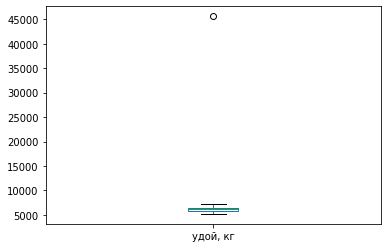

In [44]:
data_ferma["удой, кг"].plot(kind = "box");

In [45]:
max(data_ferma["удой, кг"])

45616

In [46]:
data_ferma = data_ferma.loc[data_ferma["удой, кг"] != max(data_ferma["удой, кг"])].copy()

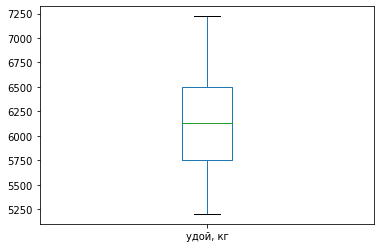

In [47]:
data_ferma["удой, кг"].plot(kind = "box");

Убрали анамалию в удое, которую заметили еще на первичном анализе

In [48]:
columns_ferma_categorial

['порода', 'тип пастбища', 'порода папы_быка', 'вкус молока', 'возраст']

In [49]:
data_ferma.columns

Index(['id', 'удой, кг', 'эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст'],
      dtype='object')

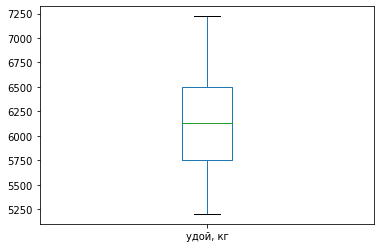

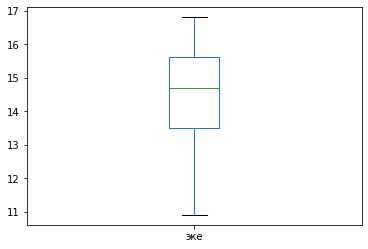

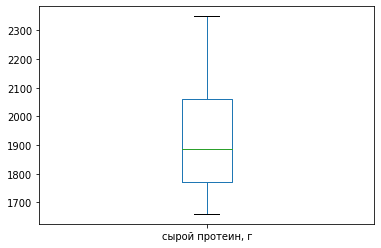

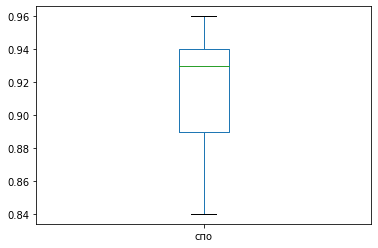

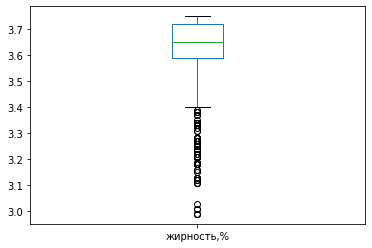

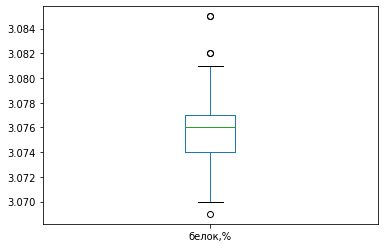

In [50]:
for item in data_ferma.columns:
    if not(item in columns_ferma_categorial) and item != "id":
        data_ferma[item].plot(kind = "box");
        plt.show()

По графикам можем заметить, что в столбцах "удой", "эке", "сырой протеин" и "спо " нет явных выбросов.
<br>
В столбце "белок" есть три явных выброса 
<br>
В столбце "жирность" достаточно много выбросов(меньшие значения) 

In [51]:
IQR = data_ferma["белок,%"].quantile(.75) - data_ferma["белок,%"].quantile(.25)
Q1 = data_ferma["белок,%"].quantile(.25)
Q3 = data_ferma["белок,%"].quantile(.75)
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
pr = (len(data_ferma.loc[data_ferma["белок,%"] < low ]) + len(data_ferma.loc[data_ferma["белок,%"] > high ])) / len(data_ferma["белок,%"])
print(f'Процент выбросов в стобце белок от общего количества - {round(pr * 100 , 3)} %')

Процент выбросов в стобце белок от общего количества - 0.796 %


In [52]:
sp1 = high - low
sp2 = max(data_ferma['белок,%']) - min(data_ferma['белок,%'])

In [53]:
print(f"Разброс без выбросов:{sp1}\nРазброс с выбросами: {sp2}")

Разброс без выбросов:0.012000000000000455
Разброс с выбросами: 0.016000000000000014


In [54]:
print(f"Разброс увеличился в {round(sp2 / sp1 , 2)} раз")

Разброс увеличился в 1.33 раз


Выбросы в столбце "белок" составляют меньше 1го %, а разброс с ними увеличивается в 1.3 раза, так что можем их удалить, это никак не отразится на данных

In [55]:
for i in range(2):
    data_ferma = data_ferma.loc[data_ferma["белок,%"] != max(data_ferma["белок,%"])].copy()
data_ferma = data_ferma.loc[data_ferma["белок,%"] != min(data_ferma["белок,%"])].copy()

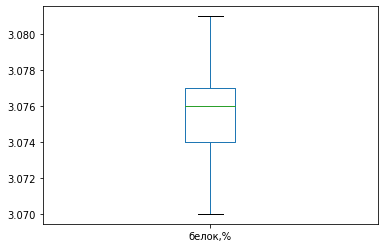

In [56]:
data_ferma["белок,%"].plot(kind = "box");

In [60]:
print(f"Отличие миниума от медианы: {data_ferma['жирность,%'].quantile(.50) - min(data_ferma['жирность,%'])}")

IQR = data_ferma["жирность,%"].quantile(.75) - data_ferma["жирность,%"].quantile(.25)
Q1 = data_ferma["жирность,%"].quantile(.25)
Q3 = data_ferma["жирность,%"].quantile(.75)

low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

Отличие миниума от медианы: 0.6599999999999997


In [61]:
print(f"нижняя граница: {low}\nВерхняя граница: {high}")

нижняя граница: 3.3949999999999996
Верхняя граница: 3.915000000000001


Видим, что разброс данных довольно маленький и все значения реальны, значит считать эти данные выбросами не будем.

Также убрал единичные выбросы в остальных стобце "Белок"

In [62]:
data_cow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   16 non-null     object 
 1   тип пастбища             16 non-null     object 
 2   порода папы_быка         16 non-null     object 
 3   имя_папы                 16 non-null     object 
 4   текущая_жирность,%       16 non-null     float64
 5   текущий_уровень_белок,%  16 non-null     float64
 6   возраст                  16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


In [63]:
#Таблица с коровами

In [64]:
data_cow.head(5)

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


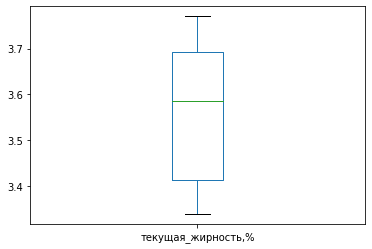

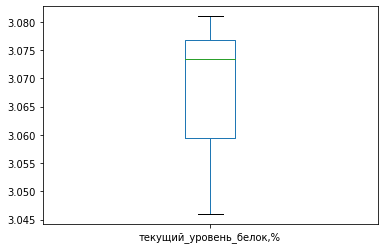

In [65]:
for item in ["текущая_жирность,%" , "текущий_уровень_белок,%"]:
    data_cow[item].plot(kind = "box")
    plt.show()

Судя по графикам для столбов "текущая_жирность,%" и "текущий_уровень_белок,%" из таблицы data_cow, в них выбросов нет, все хорошо

### 2.2 Распределения

**data_ferma**

In [66]:
data_ferma.head(2) 

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет


-----удой, кг-----


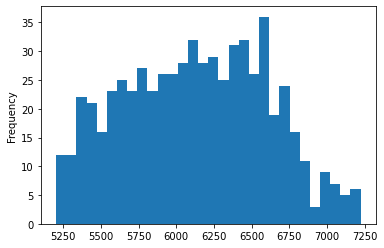

-----эке-----


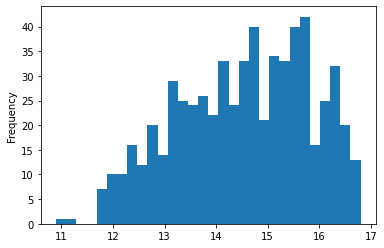

-----сырой протеин, г-----


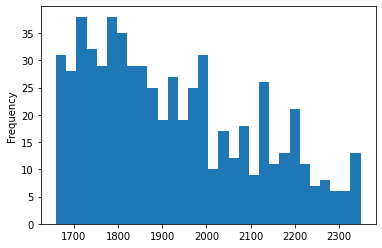

-----спо-----


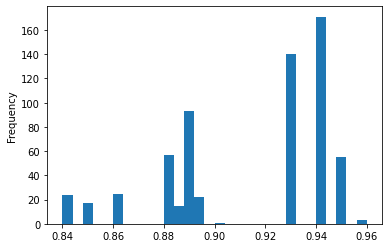

-----жирность,%-----


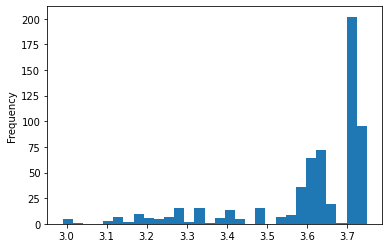

-----белок,%-----


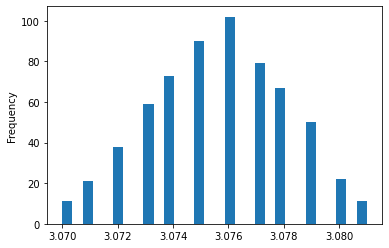

In [67]:
for item in data_ferma.columns:
    if not(item in columns_ferma_categorial) and item != "id":
        print(f"-----{item}-----")
        data_ferma[item].plot(kind = "hist" , bins = 30);
        plt.show()

По графикам можем заметить, что у столбцов "удой", "эке", "сырой протеин" и "спо ", "жирность" график не похож на нормальное распредление. Нормальное распределение имеют только данные из столбца "белок".
<br>
Также можем заметить, что у столбцов "белок" , "спо " и "жирность" есть определенные значения, которые они принмают принимают 

Нормальное распределение только у процентного содержания белка, у остальных нет

-----порода-----


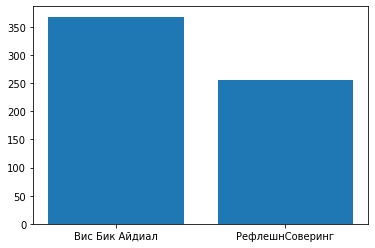

-----тип пастбища-----


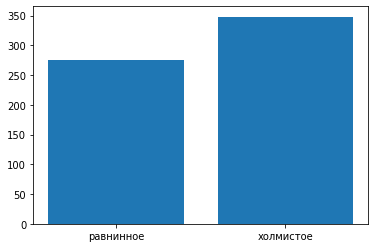

-----порода папы_быка-----


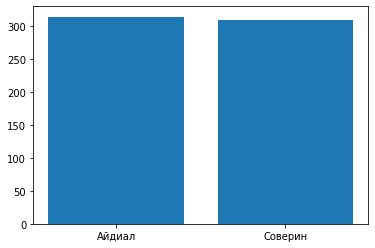

-----вкус молока-----


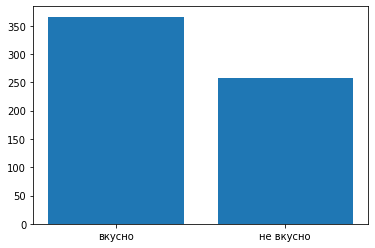

-----возраст-----


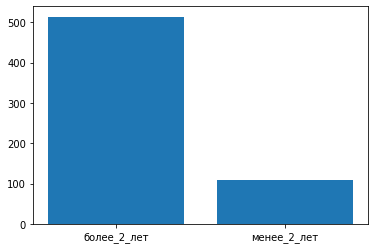

In [68]:
for item in data_ferma.columns:
    if item in columns_ferma_categorial:
        print(f"-----{item}-----")
        unique_values , counts = np.unique(data_ferma[item] , return_counts = True)
        plt.bar(unique_values , counts)
        plt.show()

У всех параматеров кроме возраста вкуса небольшие различия по количеству, у этих двух достаточно весомые

Можем заметить что в столбцах:
<br>
1. возраст - сильно доминируют коровы старше двух лет
2. вкус молока - больше вкусного молока
3. тип пастбища - коровы чаще кормятся на холмистой местности 
4. порода - больше всего породы Вис Бикк Айдиал
5. порода папы быка -  одинаковое количество пород

**data_name_dad**

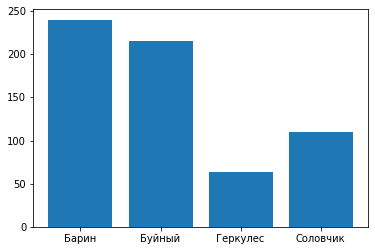

In [69]:
unique_values , counts = np.unique(data_name_dad["имя_папы"] , return_counts = True)
plt.bar(unique_values , counts);

Имена папы коров по популярности располагаются в следующем порядке(от большего к меньшему):
<br>
Барин, Буйный, Соловчик, Геркулесб, так же можно отметить, что имя Геркулес встречается очень редко по сравнению с остальными

**data_cow**

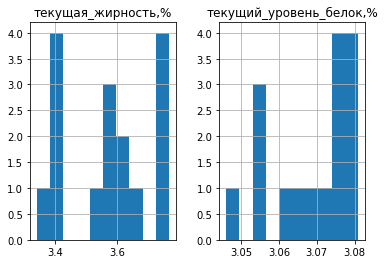

In [70]:
data_cow.hist(bins = 10);

Столбцы "текущая жирност"ь и "текущий белок" в data_cow распределены не равномерно, также видно, что часто принимают конкретые значения

Есть границы заметные промежутки в гистограммах, следовательное много каких-то конкртных значений

-----порода-----


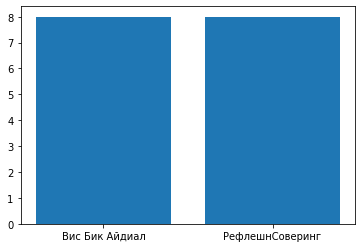

-----тип пастбища-----


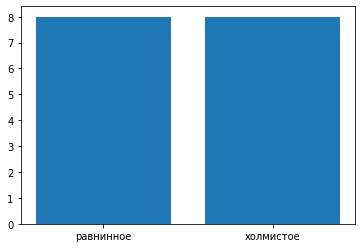

-----порода папы_быка-----


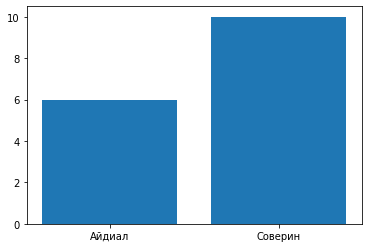

-----имя_папы-----


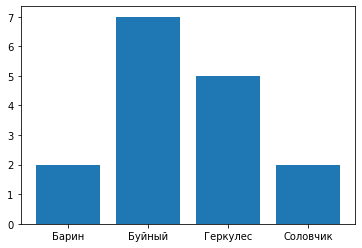

In [71]:
for item in data_cow.columns:
    if item in columns_cow_categorial:
        print(f"-----{item}-----")
        unique_values , counts = np.unique(data_cow[item] , return_counts = True)
        plt.bar(unique_values , counts)
        plt.show()

Можем заметить что в столбцах:
<br>
1. порода папы быка -  больше попроды Соверин, чем Айдиал
3. тип пастбища - коровы одинаково часто кормятся на холмистой и равнинной местности 
4. порода - одинаковое количество коров с данными породами


Имена папы коров по популярности располагаются в следующем порядке(от большего к меньшему):
<br>
Буйный, Геркулес, Соловчик,  Барин, так же можно отметить, что имена Соловчик,  Барин встречаются очень редко по сравнению с остальными

In [72]:
data_cow["текущая_жирность,%"].unique()

array([3.58, 3.54, 3.59, 3.4 , 3.64, 3.63, 3.57, 3.73, 3.68, 3.42, 3.77,
       3.34])

In [73]:
data_cow["текущий_уровень_белок,%"].unique()

array([3.076, 3.081, 3.074, 3.061, 3.053, 3.079, 3.055, 3.073, 3.046,
       3.075, 3.065, 3.069])

In [74]:
for item in ["спо" , "жирность,%" , "белок,%"]:
    print(f"-----{item}------")
    print(data_ferma[item].unique())


-----спо------
[0.89  0.885 0.93  0.94  0.895 0.95  0.96  0.85  0.84  0.86  0.88  0.9  ]
-----жирность,%------
[3.58 3.54 3.59 3.4  3.73 3.13 3.48 3.55 3.71 3.72 3.61 3.03 3.49 3.31
 3.7  3.74 3.21 3.11 3.25 3.34 3.24 3.53 3.16 3.26 3.57 3.44 3.38 3.18
 3.42 3.62 3.75 3.41 3.27 3.63 3.12 3.64 3.69 3.22 3.37 3.65 3.33 3.28
 3.35 3.32 3.23 3.01 2.99 3.39 3.19]
-----белок,%------
[3.076 3.079 3.074 3.075 3.073 3.078 3.077 3.071 3.08  3.072 3.081 3.07 ]


Подтвердилась догадка о том, что есть определенные значения, которые принимают спо, белок и жирность

**Вывод**
<br>
В ходе статистеческого анализа мы выявили и устранили анамалии, а также узнали, что у всех столбцов, кроме "белок,%" не нормальное распределение, следовательно коэфициент кореляции Пирсона использовать не будем.



## Шаг 4. Корреляционный анализ

**data_ferma**

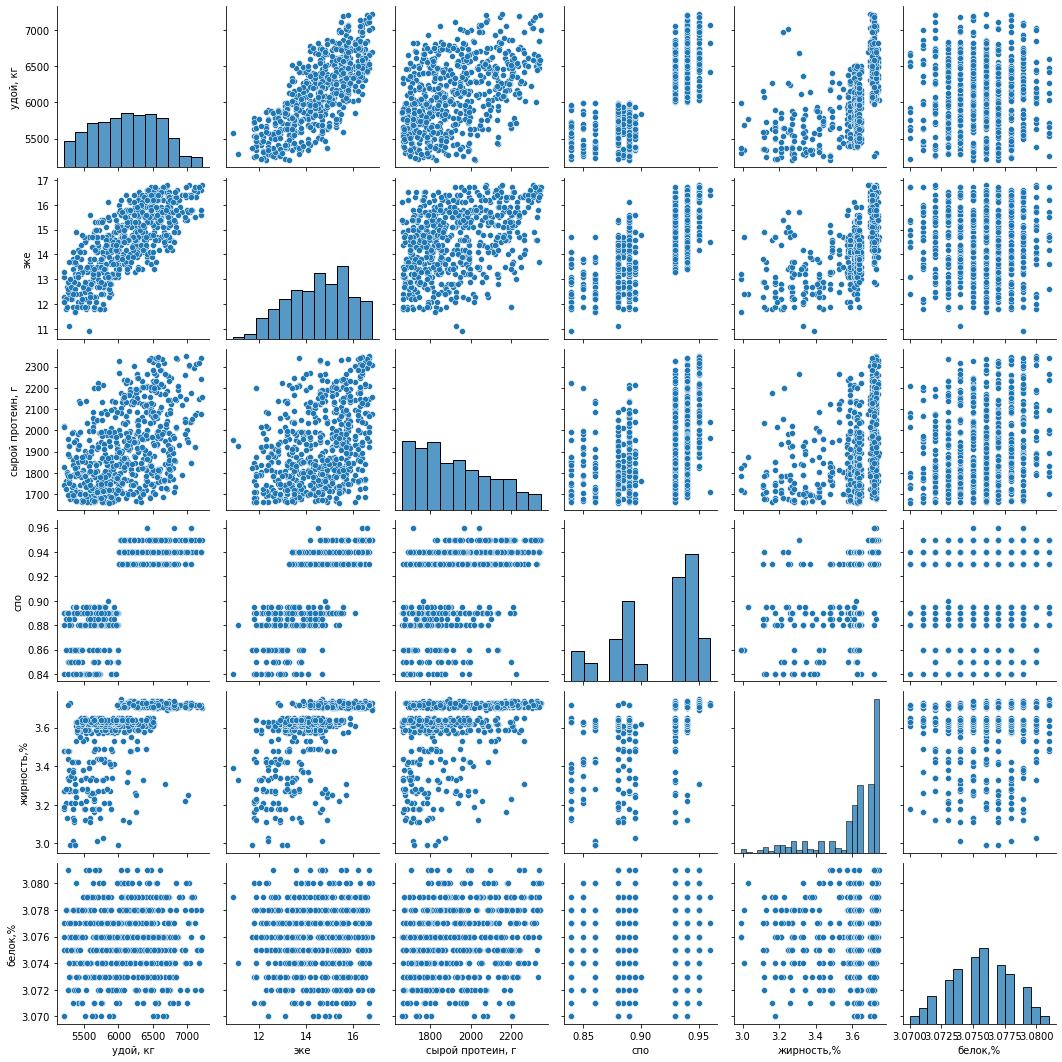

In [75]:
sns.pairplot(data_ferma[['удой, кг', 'эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст']]);

можем сразу заметить, что у СПО не линейная зависимость, дальше его учитывать не будем

In [76]:
data_ferma.corr(method = "spearman")

,id,"удой, кг",эке,"сырой протеин, г",спо,"жирность,%","белок,%"
id,1.000000,-0.004194,-0.023219,-0.042625,-0.019466,0.039144,-0.000995
"удой, кг",-0.004194,1.000000,0.764683,0.437322,0.786345,0.687403,-0.007809
эке,-0.023219,0.764683,1.000000,0.383890,0.741703,0.686893,-0.017652
"сырой протеин, г",-0.042625,0.437322,0.383890,1.000000,0.488510,0.395221,0.224131
спо,-0.019466,0.786345,0.741703,0.488510,1.000000,0.699486,0.113700
"жирность,%",0.039144,0.687403,0.686893,0.395221,0.699486,1.000000,0.048995
"белок,%",-0.000995,-0.007809,-0.017652,0.224131,0.113700,0.048995,1.000000


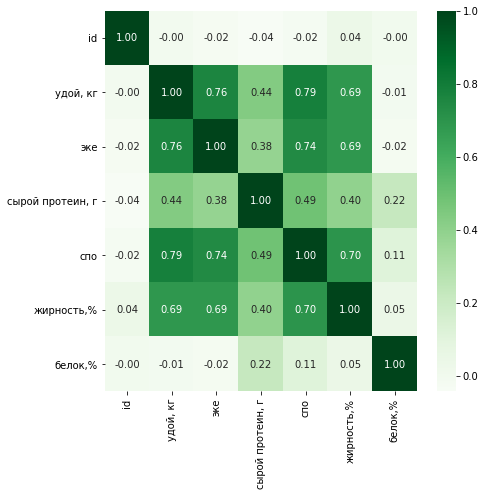

In [77]:
plt.figure(figsize=(7,7))
sns.heatmap(data_ferma.corr(method = "spearman") , annot = True , cmap = "Greens", fmt='.2f');

In [78]:
data_ferma.corr(method = "spearman")[["удой, кг"]].sort_values(by = "удой, кг" , ascending = False)

,"удой, кг"
"удой, кг",1.000000
спо,0.786345
эке,0.764683
"жирность,%",0.687403
"сырой протеин, г",0.437322
id,-0.004194
"белок,%",-0.007809


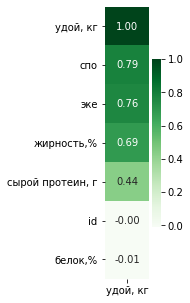

In [79]:
plt.figure(figsize=(1,5))
sns.heatmap(data_ferma.corr(method = "spearman")[["удой, кг"]].sort_values(by = "удой, кг" , ascending = False) , cmap = "Greens" , fmt = ".2f" , annot = True);

Самая большая кореляцию с целевым признаком у СПО и ЭКЕ, также есть связь у жирности и сырого протеина. У белка связи нет и id свзяи нет.

Рассмотрим мультиколлениарность у data_ferma

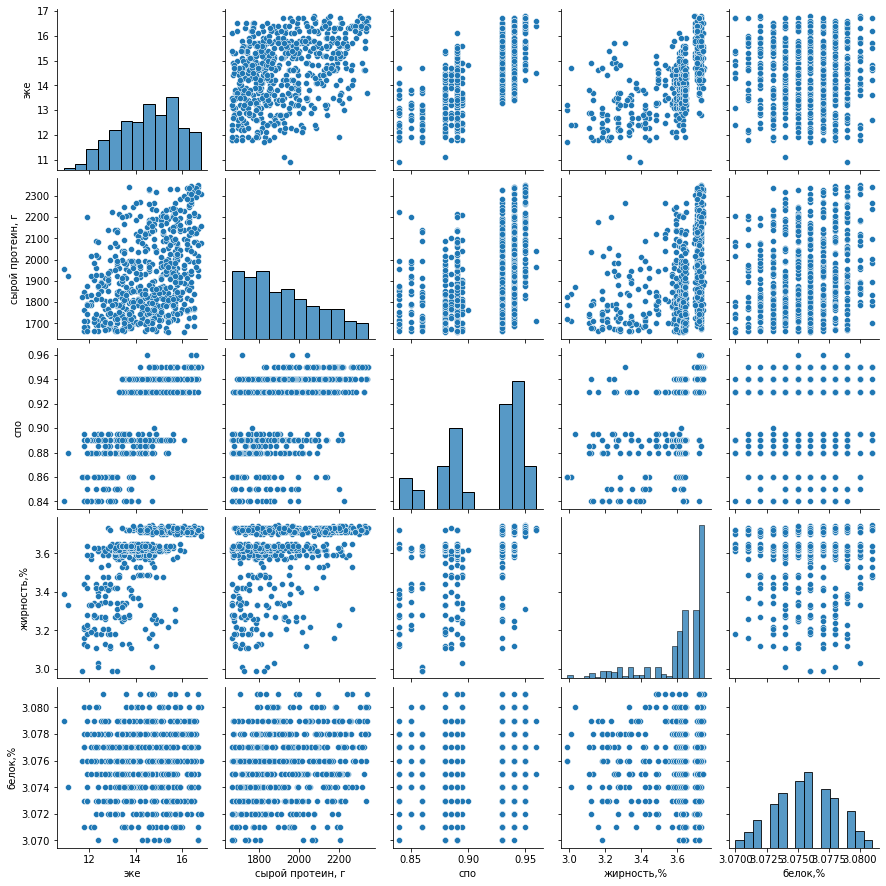

In [80]:
sns.pairplot(data_ferma[['эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст']]);

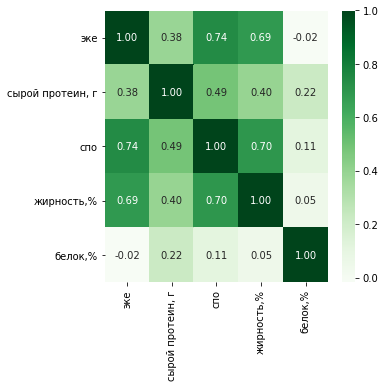

In [81]:
plt.figure(figsize=(5,5))
sns.heatmap(data_ferma[['эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст']].corr(method = "spearman") , annot = True , cmap = "Greens", fmt='.2f');

у ЭКЕ есть зависимость между СПО и жирностью, также небольшая с сырым протеином, У жирности СПО, однако коэф кореляции меньше 0.9,  а о мультиколлениарнсти мы можем говорить, когда коэф кореляции больше 0.9

In [82]:
data_ferma

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,12.9,1700,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,13.8,1994,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,вкусно,более_2_лет


In [83]:
data_ferma.phik_matrix()

interval columns not set, guessing: ['id', 'удой, кг', 'эке', 'сырой протеин, г', 'спо', 'жирность,%', 'белок,%']


,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
id,1.000000,0.000000,0.000000,0.105598,0.382619,0.613572,0.000000,0.319636,0.524392,0.000000,0.061064,0.000000
"удой, кг",0.000000,1.000000,0.718830,0.467948,0.661606,0.159864,0.274901,0.516998,0.706511,0.234394,0.178431,0.998036
эке,0.000000,0.718830,1.000000,0.453484,0.591611,0.115077,0.103464,0.173375,0.717536,0.000000,0.273181,0.772487
"сырой протеин, г",0.105598,0.467948,0.453484,1.000000,0.387282,0.085639,0.085615,0.000000,0.403898,0.221094,0.170600,0.350626
спо,0.382619,0.661606,0.591611,0.387282,1.000000,0.052108,0.145166,0.427383,0.643040,0.000000,0.572829,0.748693
порода,0.613572,0.159864,0.115077,0.085639,0.052108,1.000000,0.206840,0.093854,0.222665,0.375280,0.000000,0.053406
тип пастбища,0.000000,0.274901,0.103464,0.085615,0.145166,0.206840,1.000000,0.000000,0.000000,0.149085,0.268762,0.123505
порода папы_быка,0.319636,0.516998,0.173375,0.000000,0.427383,0.093854,0.000000,1.000000,0.000000,0.078668,0.000000,0.351328
"жирность,%",0.524392,0.706511,0.717536,0.403898,0.643040,0.222665,0.000000,0.000000,1.000000,0.000000,0.201406,0.682940
"белок,%",0.000000,0.234394,0.000000,0.221094,0.000000,0.375280,0.149085,0.078668,0.000000,1.000000,0.107450,0.000000


interval columns not set, guessing: ['id', 'удой, кг', 'эке', 'сырой протеин, г', 'спо', 'жирность,%', 'белок,%']


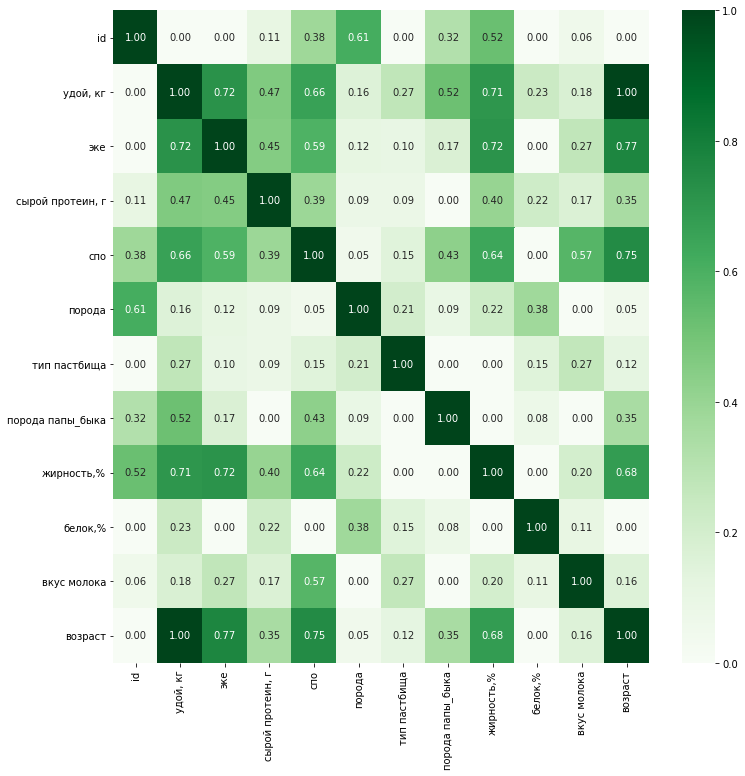

In [84]:
plt.figure(figsize=(12,12))
sns.heatmap(data_ferma.phik_matrix() , annot = True , cmap = "Greens", fmt='.2f');

interval columns not set, guessing: ['id', 'удой, кг', 'эке', 'сырой протеин, г', 'спо', 'жирность,%', 'белок,%']


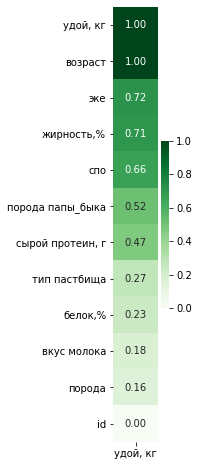

In [85]:
plt.figure(figsize=(1,8))
sns.heatmap(data_ferma.phik_matrix()[["удой, кг"]].sort_values(by = "удой, кг" , ascending = False) , cmap = "Greens" , fmt = ".2f" , annot = True);

Видим очень сильную связь между удоем и возhастом, это логично, коровы старше двух лет явно дают больше молока, чем моложе 2х лет, также есть небольшая связь у удоя с породой папы быка и типом пастбища. Маленькая связь с породой и вкусом молока

Мультиколлениарность у категориальных признаков:

interval columns not set, guessing: ['эке', 'сырой протеин, г', 'спо', 'жирность,%', 'белок,%']


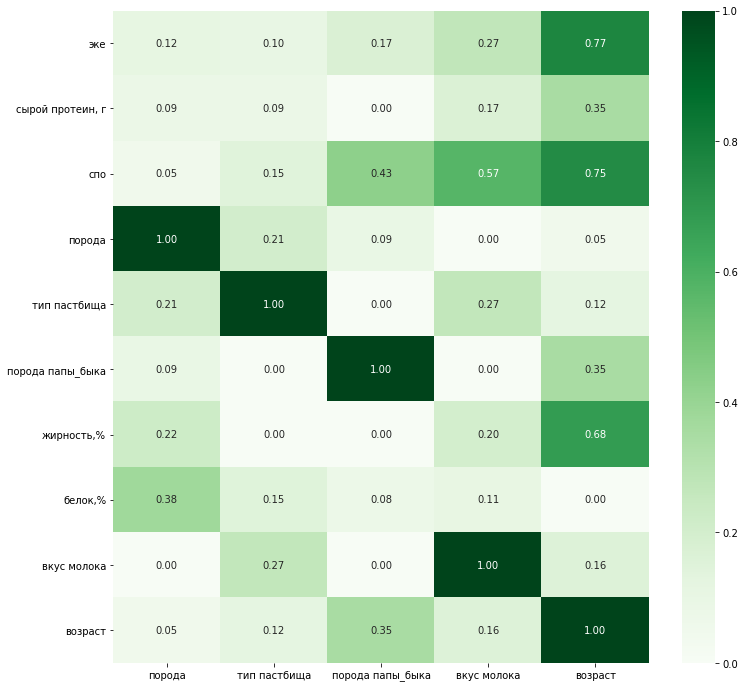

In [86]:
plt.figure(figsize=(12,12))
sns.heatmap(data_ferma[['эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст']].phik_matrix()[['порода',
       'тип пастбища', 'порода папы_быка','вкус молока', 'возраст']], annot = True , cmap = "Greens", fmt='.2f');

У возраста есть линейная связь с жиность, породой папы, СПО , протеинои и ЭКЕ, также есть небольшая связь между породой и белком, также между породой папы и СПО, однако коэф кореляции меньше 0.9 так что не учитываем это как мультиколлениарность

**data_cow**

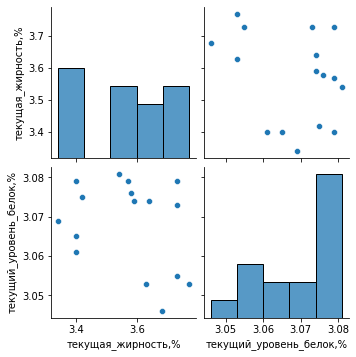

In [87]:
sns.pairplot(data_cow);

interval columns not set, guessing: ['текущая_жирность,%', 'текущий_уровень_белок,%']


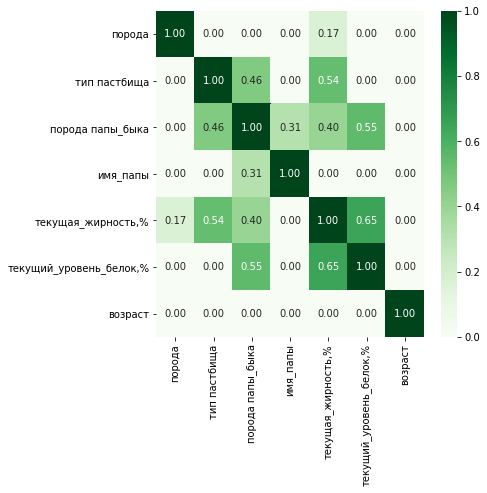

In [88]:
plt.figure(figsize=(6,6))
sns.heatmap(data_cow.phik_matrix() , annot = True , cmap = "Greens", fmt='.2f');

In [89]:
data_cow["текущая_жирность,%"].corr(data_cow["текущий_уровень_белок,%"])

-0.2953764905884578

Видим среднюю свзяь между типом пастбища и жирностью, также породой папы быка, белком, жирностью и типом пастбища, слабая связь между жирностью и текущим уровнем белка

**Вывод**

*1)*
* __Количественные данные:__ <br>
     Есть сильная линейная связь с целевым признаком у СПО и ЭКЕ, также есть линейная связь у жирности и сырого протеина. У белка связи нет и id свзяи нет(логично).
<br>
* __Категориальные данные:__
<br>
Есть очень сильная линейная связь между целевым признаком и возрастом, это логично, также есть небольшая связь у целевого признака с породой папы быка и типом пастбища. Маленькая связь с породой и вкусом молока


2)
<br>
* __Нелинейной связь между признаками.__
<br>
СПО нелинейно связан с удоем, в дальнейшем уберем нелинейность заменив его категориальным типом данным 

3)
<br>
* __Мультиколлинеарность между количественными признаками__ <br>
    Мультиколлинеарности между признаками нет, однако у ЭКЕ есть зависимость между СПО и жирностью, также небольшая с сырым протеином, У жирности СПО, однако коэф кореляции меньше 0.9, а о мультиколлениарнсти мы можем говорить, когда коэф кореляции больше 0.9
<br>
* __Мультиколлинеарность между категориальными признаками__ <br>
    У возраста есть связь с жиность, породой папы, СПО , протеинои и ЭКЕ, также есть небольшая связь между породой и белком, также между породой папы и СПО, однако коэф кореляции меньше 0.9 так что не учитываем это как мультиколлениарность

## Шаг 5. Обучение модели линейной регрессии

###  5.1 Выбераем признаки, которые подходят для нашей модели

In [90]:
data_ferma.head(5)

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [91]:
data_ferma.columns

Index(['id', 'удой, кг', 'эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст'],
      dtype='object')

In [92]:
X = data_ferma[['эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'возраст']].copy()
y = data_ferma["удой, кг"].copy()

В качестве входных признаков выбрали данные стобцы(все кроме характеристик молока и id), так как характеристики молока явно не влияют на удой, в отличие от параметров корма, пород коров и типов пастбищ.

В качестве целевого признкака - удой

### 5.2 Разбиваем данные на обучающую и тестовую выборки.

In [93]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X , y , random_state = RANDOM_STATE)

In [94]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(467, 7)
(156, 7)
(467,)
(156,)


### 5.3 Нормализуем категориальные признаки с помощью One-Hot Encoding.

In [95]:
X.columns

Index(['эке', 'сырой протеин, г', 'спо', 'порода', 'тип пастбища',
       'порода папы_быка', 'возраст'],
      dtype='object')

In [96]:
category_col = ['порода', 'тип пастбища',
       'порода папы_быка', 'возраст']
nums_col = ['эке', 'сырой протеин, г', 'спо']

In [97]:
encoder = OneHotEncoder(sparse = False , drop = "first")
encoder.fit(X_train[category_col])
X_train_cat_ohe = encoder.transform(X_train[category_col])
X_test_cat_ohe = encoder.transform(X_test[category_col])

In [98]:
X_train_cat_ohe

array([[0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [99]:
encoder_col_names = encoder.get_feature_names()

In [100]:
encoder_col_names

array(['x0_РефлешнСоверинг', 'x1_холмистое', 'x2_Соверин',
       'x3_менее_2_лет'], dtype=object)

In [101]:
X_train_cat_ohe_named = pd.DataFrame(X_train_cat_ohe , columns = encoder_col_names)
X_test_cat_ohe_named = pd.DataFrame(X_test_cat_ohe , columns = encoder_col_names)

In [102]:
X_train_cat_ohe_named

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
462,1.0,1.0,0.0,0.0
463,0.0,0.0,0.0,0.0
464,1.0,1.0,1.0,1.0
465,1.0,1.0,0.0,0.0


### 5.4 Масштабируем количественные признаки с помощью StandardScaler.

In [103]:
scaler = StandardScaler()

In [104]:
scaler.fit(X_train[nums_col])

StandardScaler()

In [105]:
X_train_scaled = scaler.transform(X_train[nums_col])

In [106]:
X_test_scaled = scaler.transform(X_test[nums_col])

In [107]:
#Небольшая проверка
X_train_scaled[: , 0].std()

1.0

In [108]:
X_train_scaled_named = pd.DataFrame(X_train_scaled , columns = nums_col)
X_test_scaled_named = pd.DataFrame(X_test_scaled , columns = nums_col)

### 5.5 Создаем модель линейной регрессии и получаем прогноз

In [109]:
#Создаем единую таблицу с категориальными и количественными данными

In [110]:
X_train = pd.concat([X_train_scaled_named , X_train_cat_ohe_named] , axis = 1)
X_test = pd.concat([X_test_scaled_named , X_test_cat_ohe_named] , axis = 1)

In [111]:
X_train.head(3)

,эке,"сырой протеин, г",спо,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет
0,1.543027,0.206082,1.426018,0.0,0.0,1.0,0.0
1,1.388625,-0.185338,0.795084,0.0,0.0,0.0,0.0
2,-0.386997,0.265882,-0.782250,0.0,0.0,0.0,0.0


In [112]:
X_test.head(3)

,эке,"сырой протеин, г",спо,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет
0,-0.695800,0.091918,-0.782250,1.0,1.0,1.0,0.0
1,-2.085417,-1.446578,-2.359584,0.0,0.0,1.0,1.0
2,1.465826,0.836702,0.795084,0.0,1.0,0.0,0.0


In [113]:
model_lr = LinearRegression()

In [114]:
model_lr.fit(X_train , y_train)

LinearRegression()

In [115]:
predictions = model_lr.predict(X_test)

### 5.6 Оценка качества модели на тестовой выборке: рассчет R²,МАЕ,RMSE. Анализ остатков с помощью графиков.

In [116]:
print(f"MAE - {mean_absolute_error(y_test , predictions):.2f}")
print(f"R2 - {r2_score(y_test , predictions):.2f}")
print(f"RMSE - {mean_squared_error(y_test , predictions , squared = False):.2f}")

MAE - 173.80
R2 - 0.78
RMSE - 217.94


Модель показывает себя лучше чем среднее арифмитическое в 76% случаеав. <br>
Средняя абслолютная ошибка состаляет 172кг

In [117]:
errors = y_test - predictions

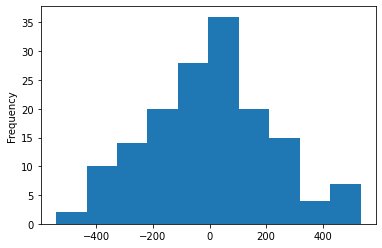

In [118]:
errors.plot(kind = "hist");

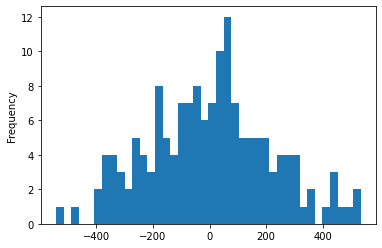

In [119]:
errors.plot(kind = "hist" , bins = 40);

Распределение похоже на нормальное, но есть выбросы в районе -600, 400 и -480б также много выбросов в районе -200 и 100

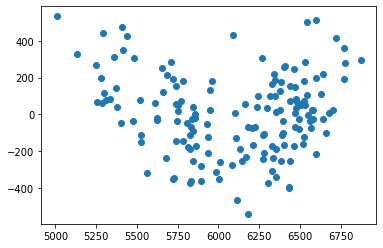

In [120]:
plt.scatter(x = predictions , y = errors);

График имеет форму рупора, это показывает, что данная модель не постоянна на больших значениях(от 6250 и выше), такую модель использовать нельзя

**Вывод**
<br>
1. Уровень R² модели - 78%
<br>
2. Распределение похоже на нормальное, но есть выбросы в районе -600, 400 и -480б также много выбросов в районе -200 и 100. График дисперсии имеет форму рупора, это показывает, что данная модель не постоянна на больших значениях(от 6250 и выше), такую модель использовать нельзя
<br>
3. Нужны дополнительные исследования.

* __----------------------------------------------Новые признаки-------------------------------------------------__

**Построение модели линейной регрессии с учётом преобразования признаков, нелинейно связанных с целевым признаком.**

In [121]:
data_ferma.head(2)

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет


**СПО**

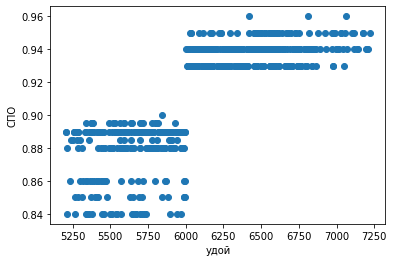

In [122]:
plt.scatter( x = data_ferma["удой, кг"] , y = data_ferma["спо"]);
plt.xlabel("удой");
plt.ylabel("СПО");

Видна четкая граница на 0.91

In [123]:
data_ferma_tmp = data_ferma.copy()

In [124]:
data_ferma_tmp["спо"] = data_ferma_tmp["спо"].apply(lambda x: "more_0.91" if x >= 0.91 else "less_0.91")

Преобразовали СПО в категорильные данные, исключив нелинейность 

**ЭКЕ**

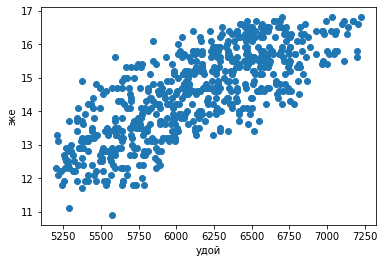

In [125]:
plt.scatter( x = data_ferma["удой, кг"] , y = data_ferma["эке"]);
plt.xlabel("удой");
plt.ylabel("эке");

In [126]:
data_ferma_tmp["эке"] = data_ferma_tmp["эке"].apply(lambda x: x**2)


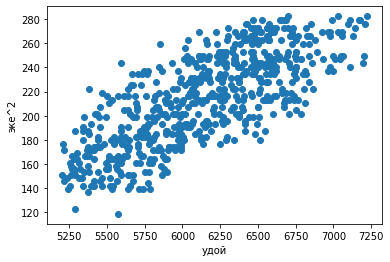

In [127]:
plt.scatter( x = data_ferma_tmp["удой, кг"] , y = data_ferma_tmp["эке"]);
plt.xlabel("удой");
plt.ylabel("эке^2");

Возвели ЭКЕ в квадрат, исключив нелинейность

(467, 7)
(156, 7)
(467,)
(156,)
MAE - 149.72
R2 - 0.83
RMSE - 190.28


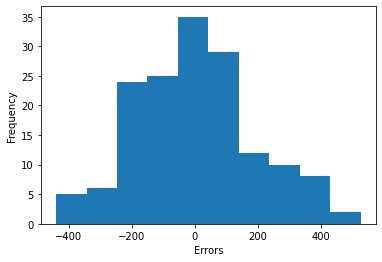

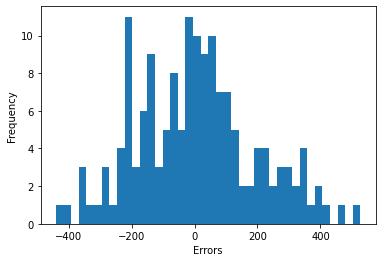

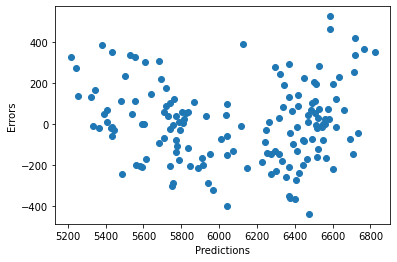

In [128]:
X_1 = data_ferma_tmp[['эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'порода папы_быка', 'возраст']].copy()
y_1 = data_ferma_tmp["удой, кг"].copy()

RANDOM_STATE = 42
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1 , y_1 , random_state = RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


category_col_1 = ['порода', 'тип пастбища',
       'порода папы_быка', 'возраст' , 'спо']
nums_col_1 = ['эке', 'сырой протеин, г']

encoder_1 = OneHotEncoder(sparse = False , drop = "first")
encoder_1.fit(X_train_1[category_col_1])
X_train_cat_ohe_1 = encoder_1.transform(X_train_1[category_col_1])
X_test_cat_ohe_1 = encoder_1.transform(X_test_1[category_col_1])

encoder_col_names_1 = encoder_1.get_feature_names()

X_train_cat_ohe_named_1 = pd.DataFrame(X_train_cat_ohe_1 , columns = encoder_col_names_1)
X_test_cat_ohe_named_1 = pd.DataFrame(X_test_cat_ohe_1 , columns = encoder_col_names_1)

#X_train_scaled_named_1.shape

#X_test_scaled_named_1.shape

scaler_1 = StandardScaler()

scaler_1.fit(X_train_1[nums_col_1])

X_train_scaled_1 = scaler_1.transform(X_train_1[nums_col_1])

X_test_scaled_1 = scaler_1.transform(X_test_1[nums_col_1])

#X_train_scaled_1[: , 0].std()

X_train_scaled_named_1 = pd.DataFrame(X_train_scaled_1 , columns = nums_col_1)
X_test_scaled_named_1 = pd.DataFrame(X_test_scaled_1 , columns = nums_col_1)

#X_train_scaled_named_1.shape

#X_test_scaled_named_1.shape

#X_test_scaled_named_1.shape

#X_test_cat_ohe_named_1.shape

X_train_1 = pd.concat([X_train_scaled_named_1 , X_train_cat_ohe_named_1] , axis = 1)
X_test_1 = pd.concat([X_test_scaled_named_1 , X_test_cat_ohe_named_1] , axis = 1)

#X_train_1.shape

#X_test_1.shape

model_lr_1 = LinearRegression()

#X_train_1.head(5)

model_lr_1.fit(X_train_1 , y_train_1)

predictions_1 = model_lr_1.predict(X_test_1)

print(f"MAE - {mean_absolute_error(y_test_1 , predictions_1):.2f}")
print(f"R2 - {r2_score(y_test_1 , predictions_1):.2f}")
print(f"RMSE - {mean_squared_error(y_test_1 , predictions_1 , squared = False):.2f}")

errors_1 = y_test_1 - predictions_1

errors_1.plot(kind = "hist");
plt.xlabel("Errors")
plt.show()

errors_1.plot(kind = "hist" , bins = 40);
plt.xlabel("Errors")
plt.show()

plt.scatter(x = predictions_1 , y = errors_1);
plt.xlabel("Predictions")
plt.ylabel("Errors")
plt.show()

**Вывод**
<br>
1. Уровень R² модели - 83%
<br>
2. Распределение стало больше похоже на нормальное, но все равно есть есть выбросы. График дисперсии также стал лучше остатки распределены более равномерно
<br>
3. Нужны дополнительные исследования.

* __----------------------------------------------Новые признаки------------------------------------------------------------------__

Новый признак из таблицы data_name_dad

In [129]:
data_name_dad

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


In [130]:
data_name_dad["имя_папы"].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [131]:
data_ferma_tmp

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,201.64,1743,less_0.91,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,163.84,2138,less_0.91,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,196.00,1854,less_0.91,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,153.76,2012,less_0.91,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,163.84,1675,less_0.91,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,237.16,1964,more_0.91,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,166.41,1700,less_0.91,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,207.36,1837,less_0.91,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,190.44,1994,less_0.91,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,вкусно,более_2_лет


In [132]:
#Соеденим по колонке id
data_ferma_plus = data_ferma_tmp.merge(data_name_dad , on = "id")

In [133]:
data_ferma_plus

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,имя_папы
0,1,5863,201.64,1743,less_0.91,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,163.84,2138,less_0.91,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,196.00,1854,less_0.91,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,153.76,2012,less_0.91,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,163.84,1675,less_0.91,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,625,6812,237.16,1964,more_0.91,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
619,626,5513,166.41,1700,less_0.91,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,Барин
620,627,5970,207.36,1837,less_0.91,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,Барин
621,628,5746,190.44,1994,less_0.91,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,Барин


In [134]:
data_ferma_plus.isna().sum()

id                  0
удой, кг            0
эке                 0
сырой протеин, г    0
спо                 0
порода              0
тип пастбища        0
порода папы_быка    0
жирность,%          0
белок,%             0
вкус молока         0
возраст             0
имя_папы            0
dtype: int64

С размерностью таблицы все в порядке

interval columns not set, guessing: ['id', 'удой, кг', 'эке', 'сырой протеин, г', 'жирность,%', 'белок,%']


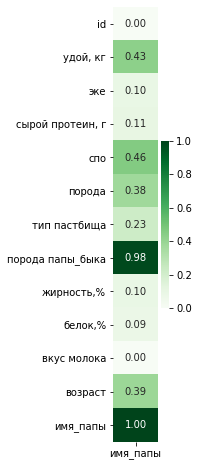

In [135]:
plt.figure(figsize=(1,8))
sns.heatmap(data_ferma_plus.phik_matrix()[["имя_папы"]] , annot = True , cmap = "Greens", fmt='.2f');

Удой зависит от имя папы, также можно заметить, что имя папы очень сильно зависит от попроды папы быка, у нас получается мультиколениарность, поэтому уберем признак с породой папы быка

(467, 7)
(156, 7)
(467,)
(156,)
MAE - 144.20
R2 - 0.8432
RMSE - 185.37


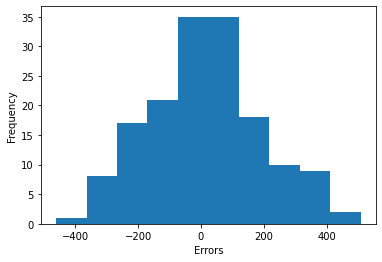

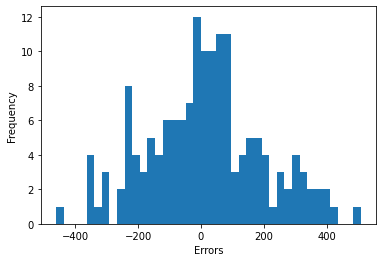

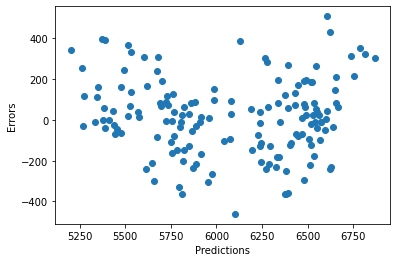

In [136]:
# X_2 = data_ferma_plus[['эке', 'сырой протеин, г', 'спо', 'порода',
#        'тип пастбища', 'порода папы_быка', 'возраст' , "имя_папы"]].copy()
X_2 = data_ferma_plus[['эке', 'сырой протеин, г', 'спо', 'порода',
       'тип пастбища', 'возраст' , "имя_папы"]].copy()
y_2 = data_ferma_tmp["удой, кг"].copy()

RANDOM_STATE = 42
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2 , y_2 , random_state = RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


# category_col_2 = ['порода', 'тип пастбища',
#        'порода папы_быка', 'возраст' , 'спо' , "имя_папы"]
category_col_2 = ['порода', 'тип пастбища',
        'возраст' , 'спо' , "имя_папы"]
nums_col_2 = ['эке', 'сырой протеин, г']

encoder_2 = OneHotEncoder(sparse = False , drop = "first")
encoder_2.fit(X_train_2[category_col_2])
X_train_cat_ohe_2 = encoder_2.transform(X_train_2[category_col_2])
X_test_cat_ohe_2 = encoder_2.transform(X_test_2[category_col_2])

encoder_col_names_2 = encoder_2.get_feature_names()

X_train_cat_ohe_named_2 = pd.DataFrame(X_train_cat_ohe_2 , columns = encoder_col_names_2)
X_test_cat_ohe_named_2 = pd.DataFrame(X_test_cat_ohe_2 , columns = encoder_col_names_2)

#X_train_scaled_named_2.shape

#X_test_scaled_named_2.shape

scaler_2 = StandardScaler()

scaler_2.fit(X_train_2[nums_col_2])

X_train_scaled_2 = scaler_2.transform(X_train_2[nums_col_2])

X_test_scaled_2 = scaler_2.transform(X_test_2[nums_col_2])

#X_train_scaled_1[: , 0].std()

X_train_scaled_named_2 = pd.DataFrame(X_train_scaled_2 , columns = nums_col_2)
X_test_scaled_named_2 = pd.DataFrame(X_test_scaled_2 , columns = nums_col_2)

#X_train_scaled_named_2.shape

#X_test_scaled_named_2.shape

#X_test_scaled_named_2.shape

#X_test_cat_ohe_named_2.shape

X_train_2 = pd.concat([X_train_scaled_named_2 , X_train_cat_ohe_named_2] , axis = 1)
X_test_2 = pd.concat([X_test_scaled_named_2 , X_test_cat_ohe_named_2] , axis = 1)

#X_train_2.shape

#X_test_2.shape

model_lr_2 = LinearRegression()

#X_train_2.head(5)

model_lr_2.fit(X_train_2 , y_train_2)

predictions_2 = model_lr_2.predict(X_test_2)

print(f"MAE - {mean_absolute_error(y_test_2 , predictions_2):.2f}")
print(f"R2 - {r2_score(y_test_2 , predictions_2):.4f}")
print(f"RMSE - {mean_squared_error(y_test_2 , predictions_2 , squared = False):.2f}")

errors_2 = y_test_2 - predictions_2

errors_2.plot(kind = "hist");
plt.xlabel("Errors")
plt.show()

errors_2.plot(kind = "hist" , bins = 40);
plt.xlabel("Errors")
plt.show()

plt.scatter(x = predictions_2 , y = errors_2);
plt.xlabel("Predictions")
plt.ylabel("Errors")
plt.show()

### Сравнение качества трёх моделей линейной регрессии.

MAE - 144.20
R2 - 0.8432
RMSE - 185.37


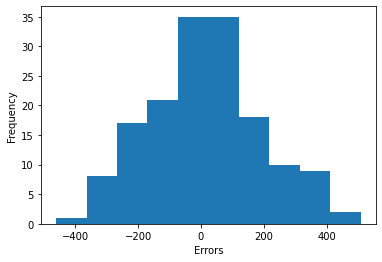

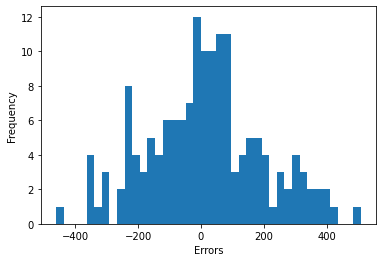

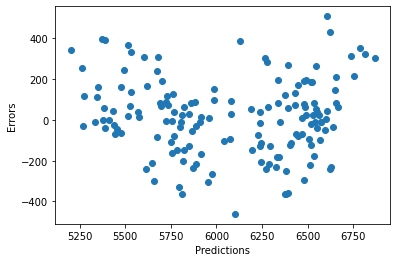

In [137]:
print(f"MAE - {mean_absolute_error(y_test_2 , predictions_2):.2f}")
print(f"R2 - {r2_score(y_test_2 , predictions_2):.4f}")
print(f"RMSE - {mean_squared_error(y_test_2 , predictions_2 , squared = False):.2f}")

errors_2.plot(kind = "hist");
plt.xlabel("Errors")
plt.show()

errors_2.plot(kind = "hist" , bins = 40);
plt.xlabel("Errors")
plt.show()

plt.scatter(x = predictions_2 , y = errors_2);
plt.xlabel("Predictions")
plt.ylabel("Errors")
plt.show()

In [138]:
#First model
m_r2 = round(r2_score(y_test , predictions) , 4)
m_mae = round(mean_absolute_error(y_test , predictions) , 2)
m_rmse = round(mean_squared_error(y_test , predictions , squared = False) , 2)
m_mse = round(mean_squared_error(y_test , predictions) , 2)

#Second model
m1_r2 = round(r2_score(y_test_1 , predictions_1) , 4)
m1_mae = round(mean_absolute_error(y_test_1 , predictions_1) , 2)
m1_rmse = round(mean_squared_error(y_test_1 , predictions_1 , squared = False) , 2)
m1_mse = round(mean_squared_error(y_test_1 , predictions_1) , 2)

#Third model
m2_r2 = round(r2_score(y_test_2 , predictions_2) , 4)
m2_mae = round(mean_absolute_error(y_test_2 , predictions_2) , 2)
m2_rmse = round(mean_squared_error(y_test_2 , predictions_2 , squared = False) , 2)
m2_mse = round(mean_squared_error(y_test_2 , predictions_2) , 2)

In [139]:
cm = [[m_r2 , m_mae , m_rmse , m_mse] ,
      [m1_r2 , m1_mae , m1_rmse , m1_mse] ,
      [m2_r2 , m2_mae , m2_rmse , m2_mse]]
col = ["R2" , "MAE" , "RMSE" , "MSE"]
index_model = ["Model 1" , "Model 2" , "Model 3"]
compare_models = pd.DataFrame(cm , columns = col , index = index_model)

In [140]:
#красивая табличка
compare_models.sort_values(by = "R2" , ascending = False)

,R2,MAE,RMSE,MSE
Model 3,0.8432,144.20,185.37,34362.28
Model 2,0.8347,149.72,190.28,36207.49
Model 1,0.7832,173.80,217.94,47500.00


**Очевидно, что 3-я модель самая эффективная
у нее лучшие показатели**

In [141]:
predictions_ser = pd.Series(predictions)

In [142]:
errors_df = errors.to_frame(name = "errors")
predictions_df = predictions_ser.to_frame(name = "predictions")


In [143]:
errors_df = errors_df.reset_index(drop = True)
predictions_df = predictions_df.reset_index(drop = True)

In [144]:
pd_errors_pred = pd.concat([errors_df , predictions_df] , axis = 1)

* __----------------------------------------------------------------------------------------------------

In [145]:
predictions_ser_1 = pd.Series(predictions_1)

errors_df_1 = errors_1.to_frame(name = "errors")
predictions_df_1 = predictions_ser_1.to_frame(name = "predictions")

errors_df_1 = errors_df_1.reset_index(drop = True)
predictions_df_1 = predictions_df_1.reset_index(drop = True)

pd_errors_pred_1 = pd.concat([errors_df_1 , predictions_df_1] , axis = 1)

* __----------------------------------------------------------------------------------------------------

In [146]:
predictions_ser_2 = pd.Series(predictions_2)

errors_df_2 = errors_2.to_frame(name = "errors")
predictions_df_2 = predictions_ser_2.to_frame(name = "predictions")

errors_df_2 = errors_df_2.reset_index(drop = True)
predictions_df_2 = predictions_df_2.reset_index(drop = True)

pd_errors_pred_2 = pd.concat([errors_df_2 , predictions_df_2] , axis = 1)

In [147]:
er = [errors , errors_1 , errors_2]
pd_e_p = [pd_errors_pred , pd_errors_pred_1 , pd_errors_pred_2]
names = ["Model 1" , "Model 2" , "Model 3"]

                 -------------------Model 1-------------------


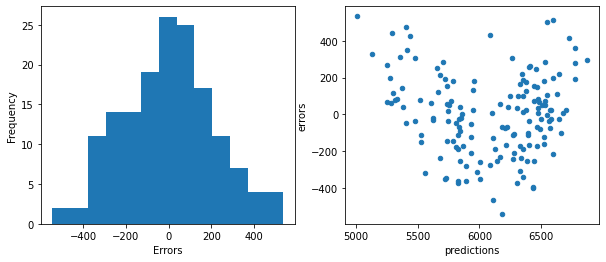

                 -------------------Model 2-------------------


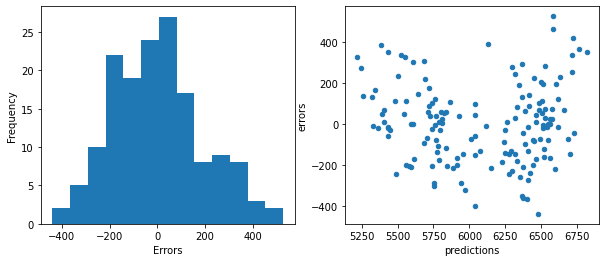

                 -------------------Model 3-------------------


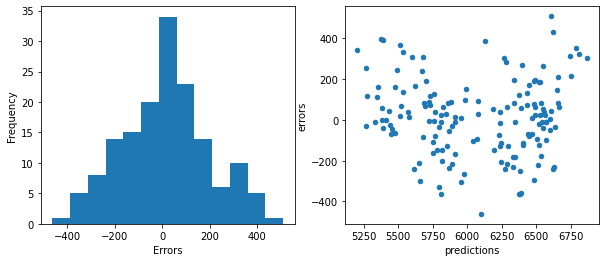

In [148]:
#Красиво расположенные графики
for i in range(3):
    print(f"                 -------------------{names[i]}-------------------")
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    pl = er[i].plot(kind = "hist" , bins = 13 , ax = ax[0]);
    pl.set_xlabel("Errors")
    pd_e_p[i].plot(kind = "scatter" , x = "predictions" , y = "errors" , ax = ax[1]);
    plt.show()
    
    

Дисперсия у 3й модели также самая равномерная, однако не идеальная. График частот также больше всего похож на нормальное у 3й меодели.

**Вывод**
<br>
Берем 3ю модель!

Доверительный интревал

In [149]:

d = st.norm.interval(confidence = 0.95, loc=np.mean(predictions_df_2), scale=st.sem(predictions_df_2))


In [150]:
print(f"Доверительный интервал для третий модели с {round(d[0][0] , 1)}кг до {round(d[1][0] , 1)}кг")

Доверительный интервал для третий модели с 6006.2кг до 6143.9кг


### 5.7 Приминение лучшей модели к данным

In [151]:
data_cow_copy = data_cow.copy()

In [152]:
data_cow.head(5)

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [153]:
ece = data_ferma["эке"].mean() * 1.05
dry = data_ferma["сырой протеин, г"].mean() * 1.05
spo = data_ferma["спо"].mean() * 1.05

In [154]:
data_cow["эке"] = ece
data_cow["сырой протеин, г"] = dry
data_cow["спо"] = spo

In [155]:
data_cow["эке"] = data_cow["эке"].apply(lambda x: x**2)
data_cow["спо"] = data_cow["спо"].apply(lambda x: "more_0.91" if x >= 0.91 else "less_0.91")

In [156]:
data_cow.head(4)

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке,"сырой протеин, г",спо
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.378833,2019.77191,more_0.91
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.378833,2019.77191,more_0.91
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.378833,2019.77191,more_0.91
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.378833,2019.77191,more_0.91


In [157]:
category_col_res = ['порода', 'тип пастбища',
        'возраст' , 'спо' , "имя_папы"]
nums_col_res = ['эке', 'сырой протеин, г']

In [158]:
ohe = encoder_2.transform(data_cow[category_col_res])
name_ohe = encoder_2.get_feature_names()

In [159]:
ohe_named = pd.DataFrame(ohe , columns = name_ohe)

In [160]:
scale_res = scaler_2.transform(data_cow[nums_col_res])

In [161]:
scale_res_named = pd.DataFrame(scale_res , columns = nums_col_res)

In [162]:
res = pd.concat([scale_res_named , ohe_named] , axis = 1)

In [163]:
res.head(4)

,эке,"сырой протеин, г",x0_РефлешнСоверинг,x1_холмистое,x2_менее_2_лет,x3_more_0.91,x4_Буйный,x4_Геркулес,x4_Соловчик
0,0.495804,0.498407,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.495804,0.498407,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,0.495804,0.498407,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.495804,0.498407,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [164]:
predictions_res = model_lr_2.predict(res)

In [165]:
data_cow_copy["Удой"] = predictions_res

In [166]:
data_cow_copy

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,Удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6607.819506
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6309.992838
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6280.476524
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6597.887661
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6545.510589
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6392.727442
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6509.109209
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6398.771290
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6326.948867
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6591.843813


## Шаг 6. Обучение модели логистической регрессии

### 6.1 Выбор подходящих входных признаков

In [167]:
data_ferma_plus_copy = data_ferma_plus.copy()

Разметка целевого признкака:
<br>
вкусно - 1
<br>
не вкусно - 0

In [168]:
data_ferma_plus_copy["вкус молока"] = data_ferma_plus_copy["вкус молока"].apply(lambda x: 1 if x == "вкусно" else 0)

In [169]:
data_ferma_plus_copy.head(1)

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,имя_папы
0,1,5863,201.64,1743,less_0.91,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,Буйный


interval columns not set, guessing: ['id', 'удой, кг', 'эке', 'сырой протеин, г', 'жирность,%', 'белок,%', 'вкус молока']


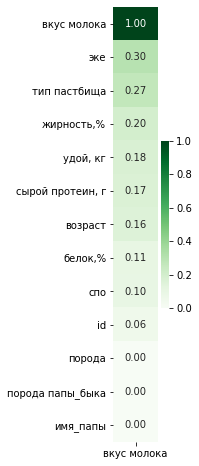

In [170]:
plt.figure(figsize=(1,8))
sns.heatmap(data_ferma_plus_copy.phik_matrix()[["вкус молока"]].sort_values(by = "вкус молока" , ascending = False) , annot = True , cmap = "Greens", fmt='.2f');

In [171]:
data_ferma_plus_copy.head(2)

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,имя_папы
0,1,5863,201.64,1743,less_0.91,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,Буйный
1,2,5529,163.84,2138,less_0.91,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,Соловчик


### 6.2 Подготовка данных для обучения линейной регрессии

In [172]:

X_logr = data_ferma_plus_copy[['эке' , "тип пастбища" ,  'жирность,%' ,  'сырой протеин, г', 'возраст' , 'спо', 'порода',
                           "белок,%" , "удой, кг"]].copy()


# X_logr = data_ferma_plus_copy[['эке' , "тип пастбища" ,  'жирность,%' ,  'сырой протеин, г', 'возраст' , 'спо',
#                            "белок,%"]].copy()

# X_logr = data_ferma_plus_copy[['эке' , "тип пастбища" ,  'жирность,%' ,  'сырой протеин, г',
#                                'возраст' ,
#                                'спо', 'имя_папы',
#                             "белок,%" , "удой, кг" , "порода"]].copy()

y_logr = data_ferma_plus_copy["вкус молока"].copy()

RANDOM_STATE = 42
X_train_logr, X_test_logr, y_train_logr, y_test_logr = train_test_split(X_logr , y_logr , random_state = RANDOM_STATE)

print(X_train_logr.shape)
print(X_test_logr.shape)
print(y_train_logr.shape)
print(y_test_logr.shape)



category_col_logr = ['порода', 'тип пастбища',
        'возраст' , 'спо' ]
nums_col_logr = ['эке', 'сырой протеин, г' , "удой, кг", "жирность,%" , "белок,%"]



# category_col_logr = ['тип пастбища',
#         'возраст' , 'спо' ]
# nums_col_logr = ['эке', 'сырой протеин, г', "жирность,%" , "белок,%"]

# category_col_logr = ['имя_папы', 'тип пастбища',
#          'возраст' , 'спо' , "порода"]
# nums_col_logr = ['эке', 'сырой протеин, г' , "удой, кг", "жирность,%" , "белок,%"]



encoder_logr = OneHotEncoder(sparse = False , drop = "first")
encoder_logr.fit(X_train_logr[category_col_logr])
X_train_cat_ohe_logr = encoder_logr.transform(X_train_logr[category_col_logr])
X_test_cat_ohe_logr = encoder_logr.transform(X_test_logr[category_col_logr])

encoder_col_names_logr = encoder_logr.get_feature_names()

X_train_cat_ohe_named_logr = pd.DataFrame(X_train_cat_ohe_logr , columns = encoder_col_names_logr)
X_test_cat_ohe_named_logr = pd.DataFrame(X_test_cat_ohe_logr , columns = encoder_col_names_logr)

#X_train_scaled_named_logr.shape

#X_test_scaled_named_logr.shape

scaler_logr = StandardScaler()

scaler_logr.fit(X_train_logr[nums_col_logr])

X_train_scaled_logr = scaler_logr.transform(X_train_logr[nums_col_logr])

X_test_scaled_logr = scaler_logr.transform(X_test_logr[nums_col_logr])

#X_train_scaled_1[: , 0].std()

X_train_scaled_named_logr = pd.DataFrame(X_train_scaled_logr , columns = nums_col_logr)
X_test_scaled_named_logr = pd.DataFrame(X_test_scaled_logr , columns = nums_col_logr)

#X_train_scaled_named_logr.shape

#X_test_scaled_named_logr.shape

#X_test_scaled_named_logr.shape

#X_test_cat_ohe_named_logr.shape

X_train_logr = pd.concat([X_train_scaled_named_logr , X_train_cat_ohe_named_logr] , axis = 1)
X_test_logr = pd.concat([X_test_scaled_named_logr , X_test_cat_ohe_named_logr] , axis = 1)

#X_train_logr.shape

#X_test_logr.shape
print("--------------------------------")
print(X_train_logr.shape)
print(X_test_logr.shape)
print(y_train_logr.shape)
print(y_test_logr.shape)

(467, 9)
(156, 9)
(467,)
(156,)
--------------------------------
(467, 9)
(156, 9)
(467,)
(156,)


### 6.3 Обучение логистической регрессии

In [173]:
logr = LogisticRegression()

In [174]:
logr.fit(X_train_logr , y_train_logr)

LogisticRegression()

In [175]:
y_pred_logr = logr.predict(X_test_logr)

### 6.4 Оценка

In [176]:
accuracy_score(y_test_logr , y_pred_logr)

0.6346153846153846

Получилась достаточно маленькая точность

In [177]:
for feature_number, feature_name in enumerate(X_train_logr.columns):
    weight = logr.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.6f}") 

эке                 : +0.651980
сырой протеин, г    : +0.174764
удой, кг            : -0.164925
жирность,%          : +0.054847
белок,%             : +0.167785
x0_РефлешнСоверинг  : -0.173103
x1_холмистое        : +0.578719
x2_менее_2_лет      : -0.240282
x3_more_0.91        : -0.680638


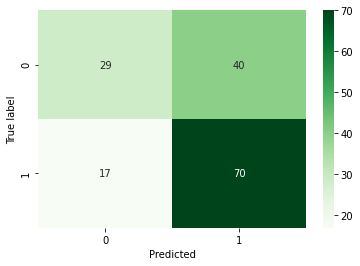

In [178]:

cm = confusion_matrix(y_test_logr, y_pred_logr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

In [179]:
recall = recall_score(y_test_logr, y_pred_logr)
precision = precision_score(y_test_logr, y_pred_logr)

print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

recall:  0.805
precision:  0.636


**Вывод**
<br>
Исходя из метрик recall и precision мы видим, что наша модель часто присваивает 1, где на самом деле 0 (precision), что для нашей ситуации является критической ошибкой. А 0 вместо 1 наша модель наоброт присваивает редко, о чем говорит метрика recall
<br>
То есть модель часто ошибочно определяет, не вкусное молоко - вкусным, что в нашей ситуации недопустимо, так как не вкусное молоко вряд ли кто-то любит, лучше уж ошибится, присвоив вкусному не вкусное

### 6.5 Вероятность принадлежности

In [180]:
y_proba = logr.predict_proba(X_test_logr)[:,1]

data = pd.DataFrame(zip(y_test_logr, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data.head() 

,y_valid,y_proba
142,1,0.854171
115,1,0.843048
83,1,0.829592
32,1,0.824799
64,1,0.817135


In [181]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 25,endpoint=False)]
print(thresholds) 

[0.1, 0.14, 0.17, 0.21, 0.24, 0.28, 0.32, 0.35, 0.39, 0.42, 0.46, 0.5, 0.53, 0.57, 0.6, 0.64, 0.68, 0.71, 0.75, 0.78, 0.82, 0.86, 0.89, 0.93, 0.96]


In [182]:


columns = []


for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)


data.sample(5)

,y_valid,y_proba,y_pred_0.1,y_pred_0.14,y_pred_0.17,y_pred_0.21,y_pred_0.24,y_pred_0.28,y_pred_0.32,y_pred_0.35,...,y_pred_0.64,y_pred_0.68,y_pred_0.71,y_pred_0.75,y_pred_0.78,y_pred_0.82,y_pred_0.86,y_pred_0.89,y_pred_0.93,y_pred_0.96
73,0,0.536796,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
138,0,0.662565,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
95,1,0.555767,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
92,0,0.691028,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
27,0,0.269151,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
def count_eq(x , y):
    k=0
    for i in range(len(x)):
        if x[i] == 0 and y[i] == 1:
            k+=1
    return k

In [184]:
for item in data.columns:
    if not(item in ["y_valid" , "y_proba"]):
        print(f"----{item}----")
        print(count_eq(data["y_valid"], data[item]))
        

----y_pred_0.1----
69
----y_pred_0.14----
69
----y_pred_0.17----
69
----y_pred_0.21----
69
----y_pred_0.24----
69
----y_pred_0.28----
64
----y_pred_0.32----
64
----y_pred_0.35----
61
----y_pred_0.39----
59
----y_pred_0.42----
56
----y_pred_0.46----
47
----y_pred_0.5----
40
----y_pred_0.53----
35
----y_pred_0.57----
30
----y_pred_0.6----
22
----y_pred_0.64----
19
----y_pred_0.68----
10
----y_pred_0.71----
5
----y_pred_0.75----
1
----y_pred_0.78----
1
----y_pred_0.82----
0
----y_pred_0.86----
0
----y_pred_0.89----
0
----y_pred_0.93----
0
----y_pred_0.96----
0


При пороге в 0.82 критических ошибок не возникает, значит устанавливаем такой порог

In [185]:
# for item in data.columns:
#     if not(item in ["y_valid" , "y_proba"]):
#         print(f"----{item}----")
#         precision = precision_score(data["y_valid"], data[item])
#         print(round(precision , 2))
        

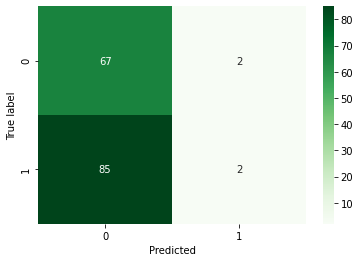

In [186]:
cm1 = confusion_matrix(y_test_logr, data["y_pred_0.82"])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Однако установив такой порог мы получаем только два правильно предсказанных вкусных молока, зато точно не купим корову, которая дает не вкусное молоко

### 6.6 Приминение модели

In [187]:
data_cow["удой, кг"] = data_cow_copy["Удой"].copy()

In [188]:
data_cow

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке,"сырой протеин, г",спо,"удой, кг"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.378833,2019.77191,more_0.91,6607.819506
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.378833,2019.77191,more_0.91,6309.992838
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6280.476524
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.378833,2019.77191,more_0.91,6597.887661
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6545.510589
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,233.378833,2019.77191,more_0.91,6392.727442
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,233.378833,2019.77191,more_0.91,6509.109209
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,233.378833,2019.77191,more_0.91,6398.771290
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,233.378833,2019.77191,more_0.91,6326.948867
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,233.378833,2019.77191,more_0.91,6591.843813


In [189]:

X_train_logr_res = data_cow[['эке' , "тип пастбища" ,  'текущая_жирность,%' ,  'сырой протеин, г', 'возраст' , 'спо', 'порода',
                           "текущий_уровень_белок,%" , "удой, кг"]].copy()

# X_logr = data_ferma_plus_copy[['эке' , "тип пастбища" ,  'жирность,%' ,  'сырой протеин, г', 'возраст' , 'спо', 'порода',
#                            "белок,%" , "удой, кг"]].copy()


RANDOM_STATE = 42


category_col_logr = ['порода', 'тип пастбища',
        'возраст' , 'спо' ]
nums_col_logr = ['эке', 'сырой протеин, г' , "удой, кг", "текущая_жирность,%" , "текущий_уровень_белок,%"]

# category_col_logr = ['имя_папы', 'тип пастбища',
#          'возраст' , 'спо' , "порода"]
# nums_col_logr = ['эке', 'сырой протеин, г' , "удой, кг", "текущая_жирность,%" , "текущий_уровень_белок,%"]



X_train_cat_ohe_logr_res = encoder_logr.transform(X_train_logr_res[category_col_logr])


encoder_col_names_logr = encoder_logr.get_feature_names()

X_train_cat_ohe_named_logr_res = pd.DataFrame(X_train_cat_ohe_logr_res , columns = encoder_col_names_logr)






X_train_scaled_logr_res = scaler_logr.transform(X_train_logr_res[nums_col_logr])


X_train_scaled_named_logr_res = pd.DataFrame(X_train_scaled_logr_res , columns = nums_col_logr)


#X_train_scaled_named_logr.shape

#X_test_scaled_named_logr.shape

#X_test_scaled_named_logr.shape

#X_test_cat_ohe_named_logr.shape

X_train_logr_res = pd.concat([X_train_scaled_named_logr_res , X_train_cat_ohe_named_logr_res] , axis = 1)




In [190]:
X_train_logr_res

,эке,"сырой протеин, г","удой, кг","текущая_жирность,%","текущий_уровень_белок,%",x0_РефлешнСоверинг,x1_холмистое,x2_менее_2_лет,x3_more_0.91
0,0.495804,0.498407,0.979436,-0.199680,0.148243,0.0,1.0,0.0,1.0
1,0.495804,0.498407,0.356197,-0.446864,2.160727,0.0,0.0,1.0,1.0
2,0.495804,0.498407,0.294430,-0.137883,-0.656751,1.0,0.0,0.0,1.0
3,0.495804,0.498407,0.958652,-1.312010,-5.889209,1.0,1.0,0.0,1.0
4,0.495804,0.498407,0.849047,0.171097,-0.656751,1.0,0.0,0.0,1.0
5,0.495804,0.498407,0.529329,0.109301,-9.109183,1.0,0.0,1.0,1.0
6,0.495804,0.498407,0.772872,-0.261476,1.355733,0.0,0.0,0.0,1.0
7,0.495804,0.498407,0.541977,-1.312010,1.355733,1.0,1.0,1.0,1.0
8,0.495804,0.498407,0.391679,0.727262,-8.304189,0.0,1.0,0.0,1.0
9,0.495804,0.498407,0.946005,0.727262,-1.059247,1.0,0.0,0.0,1.0


In [191]:
y_pred_res = logr.predict(X_train_logr_res)

In [192]:
data_cow["Вкус_0.5"] = y_pred_res

In [193]:
data_cow

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке,"сырой протеин, г",спо,"удой, кг",Вкус_0.5
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.378833,2019.77191,more_0.91,6607.819506,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.378833,2019.77191,more_0.91,6309.992838,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6280.476524,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.378833,2019.77191,more_0.91,6597.887661,0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6545.510589,0
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,233.378833,2019.77191,more_0.91,6392.727442,0
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,233.378833,2019.77191,more_0.91,6509.109209,1
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,233.378833,2019.77191,more_0.91,6398.771290,1
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,233.378833,2019.77191,more_0.91,6326.948867,0
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,233.378833,2019.77191,more_0.91,6591.843813,0


При стандартном пороговом значении получаются следующии результаты

In [194]:
y_proba_res = logr.predict_proba(X_train_logr_res)[:,1]

In [195]:
y_proba_res

array([0.69078187, 0.60148845, 0.50831263, 0.39176545, 0.48968398,
       0.16105494, 0.61261911, 0.64660076, 0.38541288, 0.47644502,
       0.23356087, 0.6497441 , 0.45766008, 0.76026824, 0.1675698 ,
       0.42679327])

При пороговым значении, вычисленном ранее для максимизации precision, у всех коров получится не вкусное молоко.

In [197]:
data_cow

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке,"сырой протеин, г",спо,"удой, кг",Вкус_0.5
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.378833,2019.77191,more_0.91,6607.819506,вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.378833,2019.77191,more_0.91,6309.992838,вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6280.476524,вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.378833,2019.77191,more_0.91,6597.887661,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6545.510589,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,233.378833,2019.77191,more_0.91,6392.727442,не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,233.378833,2019.77191,more_0.91,6509.109209,вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,233.378833,2019.77191,more_0.91,6398.771290,вкусно
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,233.378833,2019.77191,more_0.91,6326.948867,не вкусно
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,233.378833,2019.77191,more_0.91,6591.843813,не вкусно


## Шаг 7.Итоговые выводы

* __1) Прогнозы вкуса молока и удоя коров «ЭкоФермы» в одной таблице.__

In [198]:
data_cow.columns

Index(['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы',
       'текущая_жирность,%', 'текущий_уровень_белок,%', 'возраст', 'эке',
       'сырой протеин, г', 'спо', 'удой, кг', 'Вкус_0.5'],
      dtype='object')

In [199]:
data_cow[['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы',
       'текущая_жирность,%', 'текущий_уровень_белок,%', 'возраст', 'эке',
       'сырой протеин, г', 'спо', 'удой, кг' , "Вкус_0.5"]]

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке,"сырой протеин, г",спо,"удой, кг",Вкус_0.5
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.378833,2019.77191,more_0.91,6607.819506,вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.378833,2019.77191,more_0.91,6309.992838,вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6280.476524,вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,233.378833,2019.77191,more_0.91,6597.887661,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6545.510589,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,233.378833,2019.77191,more_0.91,6392.727442,не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,233.378833,2019.77191,more_0.91,6509.109209,вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,233.378833,2019.77191,more_0.91,6398.771290,вкусно
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,233.378833,2019.77191,more_0.91,6326.948867,не вкусно
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,233.378833,2019.77191,more_0.91,6591.843813,не вкусно


* __2) Коровы, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко.__

In [200]:
data_cow.loc[(data_cow["удой, кг"] > 6000) & (data_cow["Вкус_0.5"] == "вкусно")][['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы',
       'текущая_жирность,%', 'текущий_уровень_белок,%', 'возраст', 'эке',
       'сырой протеин, г', 'спо', 'удой, кг']]

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке,"сырой протеин, г",спо,"удой, кг"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,233.378833,2019.77191,more_0.91,6607.819506
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,233.378833,2019.77191,more_0.91,6309.992838
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,233.378833,2019.77191,more_0.91,6280.476524
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,233.378833,2019.77191,more_0.91,6509.109209
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,233.378833,2019.77191,more_0.91,6398.771290
13,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,233.378833,2019.77191,more_0.91,6097.335846
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,233.378833,2019.77191,more_0.91,6326.948867


* __3.1)Сколько коров он может купить из стада на продажу с минимальным риском для себя?__ 
    С минимальным риском ему лучше не покупать у данной фермы, так как модель показала, что при precision = 1, у всех коров из данной фермы молоко не вкусное. Однако при пороге логической регрессии 50% можно купить 7 коров.



* __3.2)Какие ещё рекомендации можно ему дать?__ 
    Выбрать в качестве поставщика другую ферму или собрать больше данных о коровах, чтобы мы могли лучше обучить модель


* __3.1)Какие способы улучшения качества регрессионной модели вы использовали в этой задаче?__ 
    Исключали нелинейность, путем возведения в квадрат и перевода количественных данных в категориальные.
    Добавляли новые данные
    Регулировали порог в логистической регрессии
    
   



* __3.2)Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как? Если нет, то почему?__ 
    Можноб если получить найти дополнительные данные, особенно данные, которые сильно влияют на вкус молока, а то кореляция между входными признаками и вкусом молока очень мала.
    
    
 


* __3.3)Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов??__ 
    recall и precision. Precision оценивает точность, с которой модель присваивает объектам класс 1. Она реагирует на ошибки первого рода, однако не реагирует на ошибки второго. Recall измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса. Её «слепое пятно» противоположно precision: она сосредоточена на ошибках второго рода и никак не учитывает ошибки первого. В нашем случае была важна метрика precision
    
    